<a href="https://colab.research.google.com/github/LeeYuuuan/RL/blob/main/DeepQlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import torch.nn.init as init


In [ ]:
# prompt: print cuda version and torch version

print(torch.version.cuda)
print(torch.__version__)


In [3]:
class DeepQNetwork(nn.Module):
    def __init__(self, state_size=2, action_size=5):
        super(DeepQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, action_size)
        init.normal_(self.fc1.weight, mean=0.0, std=0.02)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [ ]:
dqn = DeepQNetwork()
dqn(torch.Tensor([1, 2]))

tensor([-0.1999, -0.0857, -0.1064, -0.1366,  0.0310], grad_fn=<ViewBackward0>)

In [246]:
type(float(0))

float

In [4]:
class Environment:
    def __init__(self, disk_number=1, x_range=(float(0), float(4)), y_range=(float(0), float(4)), divided_length=0.1, radius=1.2, moving_step=0.1):
        self.disk_number = disk_number
        self.x_range = x_range
        self.y_range = y_range
        self.divided_length = divided_length
        self.radius = radius
        self.moving_step = moving_step

        self.points = None
        self.load_points()

        self.number_current_coverd = 0

        # define action space
        if self.disk_number == 1:
            self.action_space = [0, 1, 2, 3, 4] # 0: up, 1: down, 2: left, 3: right, 4: stay
            self.state = np.array([.0, .0])
        else:
            return NotImplementedError

    def random_choice_action(self):
        if self.disk_number == 1:
            return random.choice(self.action_space)
        else:
            return NotImplementedError

    def update_coverd_number(self):
        """ update the number of points covered by the disk"""
        if self.disk_number == 1:
            self.number_current_coverd = sum(np.linalg.norm(self.state - point) <= self.radius for point in self.points)
        else:
            return NotImplementedError

    def get_reward(self):
        """ return the reward"""
        if self.disk_number == 1:
            return sum(np.linalg.norm(self.state - point) <= self.radius for point in self.points) - self.number_current_coverd
            # return sum(np.linalg.norm(self.state - point) <= self.radius for point in self.points)
        else:
            return NotImplementedError


    def reset(self, initialize_method=np.array([.2, .2])):
        initialize_method = initialize_method.astype(np.float32)
        if self.disk_number == 1:

            if isinstance(initialize_method, np.ndarray) and initialize_method.shape == (2,):
                self.state = initialize_method
            if isinstance(initialize_method, list) and len(initialize_method) == 2:
                self.state = np.array(initialize_method)
            if isinstance(initialize_method, tuple) and len(initialize_method) == 2:
                self.state = np.array(initialize_method)
            if isinstance(initialize_method, str) and initialize_method == "random":
                self.state = np.array([random.uniform(*self.x_range), random.uniform(*self.y_range)])


            self.update_coverd_number()
            return self.state
        else:
            return NotImplementedError

    def step(self, action):
        flag = 0 # 0: not out of bounds, 1: out of bounds (reward -= 1)

        if self.disk_number == 1:
            if action == 0:
                self.state[1] += self.moving_step
            elif action == 1:
                self.state[1] -= self.moving_step
            elif action == 2:
                self.state[0] -= self.moving_step
            elif action == 3:
                self.state[0] += self.moving_step

        if self.state[0] < self.x_range[0]:
            self.state[0] = self.x_range[0]
            flag = 1


        if self.state[0] > self.x_range[1]:
            self.state[0] = self.x_range[1]
            flag = 1

        if self.state[1] < self.y_range[0]:
            self.state[1] = self.y_range[0]
            flag = 1

        if self.state[1] > self.y_range[1]:
            self.state[1] = self.y_range[1]
            flag = 1

        reward = self.get_reward()
        if flag == 0 and action != 3:
            reward -= 0.05
        self.update_coverd_number()
        if flag == 1:
            reward -= 4 # out of bounds
        return self.state, reward



    def load_points(self, point_pth="UserDistribution.txt"):
        """load point from txt.

        Args:
            point_pth (str): file path.
        """
        points = []
        with open(point_pth, 'r') as f:
            for line in f.readlines():
                if len(line.strip()) == 11:
                    points.append(np.array([float(line.strip()[0:4]), float(line.strip()[7:11])]))

        self.points = points


    def render(self):
        fig, ax = plt.subplots()
        plt.xlim((-2, 6))
        plt.ylim((-2, 6))
        plt.xticks(np.arange(-2, 6, self.divided_length), labels=None)
        plt.yticks(np.arange(-2, 6, self.divided_length), labels=None)

        # ax.tick_params(axis='x', which='both', labelbottom=False)
        # ax.tick_params(axis='y', which='both', labelleft=False)

        ax.xaxis.set_major_locator(MultipleLocator(1))
        ax.xaxis.set_minor_locator(MultipleLocator(0.1))

        ax.yaxis.set_major_locator(MultipleLocator(1))
        ax.yaxis.set_minor_locator(MultipleLocator(0.1))


        ax.tick_params(which='minor', length=4)
        ax.tick_params(which='major', length=7)


        ax.grid(which='major', linestyle='-', linewidth='0.5', color='black')
        ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')


        for point in self.points:
            plt.scatter(point[0], point[1], s=10)

        colors = ['red', 'yellow', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'brown', 'pink']
        color = colors[1 % len(colors)]
        if self.disk_number == 1:
            disk = self.state
            disk = plt.Circle((disk[0], disk[1]), self.radius, alpha=0.5, color=color)
            ax.add_patch(disk)
        else:
            return NotImplementedError

        plt.show()

In [6]:
class DQNAgent:
    def __init__(self, env=Environment(), gamma=0.9, learning_rate=0.001, batch_size=64, epsilon=0.9, epsilon_decay=0.95, min_epsilon=0.01, max_buffer_size=10000):
        self.env = env

        self.gamma = gamma
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.q_network = DeepQNetwork()
        self.target_network = DeepQNetwork()
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=learning_rate)
        self.loss_fn = nn.MSELoss()
        self.learning_rate = learning_rate
        self.replay_buffer = []
        self.max_buffer_size = max_buffer_size
        self.loss = []
        self.reward = []
        self.epsd = 0

    def get_action(self, state):
        # get action
        if random.uniform(0, 1) < self.epsilon:
            return self.env.random_choice_action()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()

    def update_q_network(self):
        self.optimizer.zero_grad()

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states_tensor = torch.FloatTensor(states)
        actions_tensor = torch.LongTensor(actions)
        rewards_tensor = torch.FloatTensor(rewards)
        next_states_tensor = torch.FloatTensor(next_states)
        q_values = self.q_network(states_tensor).gather(1, actions_tensor.unsqueeze(1)).squeeze(1)

        with torch.no_grad():

            next_q_values = self.target_network(next_states_tensor).max(1)[0]

            target_q_values = rewards_tensor + self.gamma * next_q_values
        loss = nn.functional.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), 1.0)
        self.optimizer.step()


        return loss.item()





    def train(self, num_episodes=1000):
        rewards = []

        for episode in range(num_episodes):
            state = self.env.reset()
            total_reward = 0
            total_loss = 0

            for step in range(60):
                action = self.get_action(state)
                next_state, reward = self.env.step(action)
                self.replay_buffer.append((state, action, reward, next_state))

                if len(self.replay_buffer) > self.max_buffer_size:
                    self.replay_buffer.pop(0)

                total_reward += reward
                state = next_state

                if len(self.replay_buffer) > self.batch_size:
                    loss_t = self.update_q_network()
                    total_loss += loss_t
                    # self.target_network.load_state_dict(self.q_network.state_dict())




            self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)
            # adjust_learning_rate(self.optimizer, self.learning_rate)

            if episode % 10 == 0:
                self.target_network.load_state_dict(self.q_network.state_dict())
                print("===============================Update Target Network===============================")
                print()

            print(f"episode: {episode}, Total rewards: {total_reward}, Current loss: {total_loss}, epsilon: {self.epsilon}")
            rewards.append(total_reward)
            self.loss.append(total_loss)
            self.reward.append(total_reward)
        self.epsd += episode
        return rewards


    def inference(self, num_steps=30):
        state = self.env.reset()
        self.epsilon = 0
        for step in range(num_steps):
            action = self.get_action(state)
            next_state, reward = self.env.step(action)
            print(f"Step: {step}, State: {state}, Action: {action}, Next State: {next_state}, Reward: {reward}")
            self.env.state = next_state
            state = next_state

def adjust_learning_rate(optimizer, initial_lr):
    if initial_lr <= 0.0005:
        return
    lr = initial_lr * 0.997
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr






In [ ]:
- timestep = 50, 100 update target network
- change init pos
- change network
- train_(target q value) ---- q_value (get action)


## test

In [ ]:
env = Environment(moving_step=0.1)
agent = DQNAgent(env, epsilon_decay=0.99)
rewards = agent.train(num_episodes=400)
plt.plot(rewards)
plt.show()

===============================Update Target Network===============================

episode: 0, Total rewards: -22.20000000000001, Current loss: 0, epsilon: 0.891
episode: 1, Total rewards: -1.0000000000000004, Current loss: 47.71167066693306, epsilon: 0.88209
episode: 2, Total rewards: -5.299999999999998, Current loss: 33.88739912211895, epsilon: 0.8732691
episode: 3, Total rewards: -2.9499999999999966, Current loss: 30.85804432630539, epsilon: 0.8645364090000001
episode: 4, Total rewards: -3.9999999999999982, Current loss: 26.708698257803917, epsilon: 0.85589104491
episode: 5, Total rewards: -24.300000000000008, Current loss: 29.753785490989685, epsilon: 0.8473321344609
episode: 6, Total rewards: -0.9999999999999987, Current loss: 34.23839992284775, epsilon: 0.8388588131162911
episode: 7, Total rewards: -9.100000000000017, Current loss: 30.05471135675907, epsilon: 0.8304702249851281
episode: 8, Total rewards: 4.000000000000004, Current loss: 30.899844706058502, epsilon: 0.8221655227

In [8]:
agent.inference()

Step: 0, State: [0.3 0.2], Action: 3, Next State: [0.3 0.2], Reward: 1
Step: 1, State: [0.4 0.2], Action: 3, Next State: [0.4 0.2], Reward: 0
Step: 2, State: [0.5 0.2], Action: 3, Next State: [0.5 0.2], Reward: 0
Step: 3, State: [0.6 0.2], Action: 3, Next State: [0.6 0.2], Reward: 0
Step: 4, State: [0.70000005 0.2       ], Action: 3, Next State: [0.70000005 0.2       ], Reward: 0
Step: 5, State: [0.8000001 0.2      ], Action: 3, Next State: [0.8000001 0.2      ], Reward: 0
Step: 6, State: [0.9000001 0.2      ], Action: 3, Next State: [0.9000001 0.2      ], Reward: 1
Step: 7, State: [1.0000001 0.2      ], Action: 3, Next State: [1.0000001 0.2      ], Reward: 1
Step: 8, State: [1.1000001 0.2      ], Action: 3, Next State: [1.1000001 0.2      ], Reward: 1
Step: 9, State: [1.1000001 0.3      ], Action: 0, Next State: [1.1000001 0.3      ], Reward: 0.95
Step: 10, State: [1.1000001 0.4      ], Action: 0, Next State: [1.1000001 0.4      ], Reward: -0.05
Step: 11, State: [1.1000001 0.5      ],

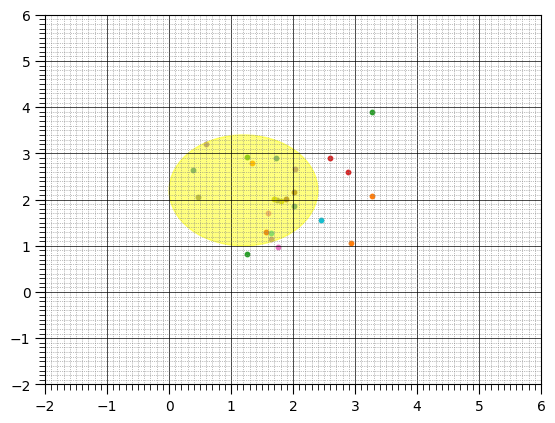

In [9]:
agent.env.render()

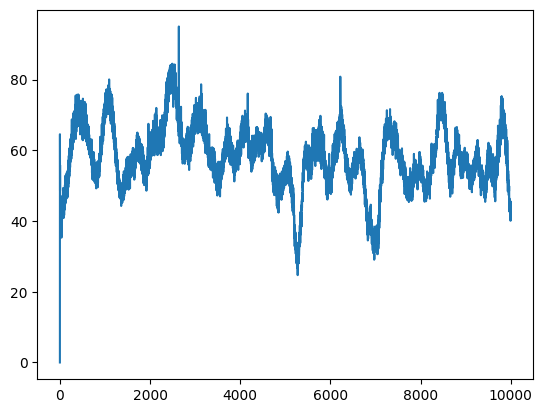

In [384]:
plt.plot(agent.loss)
plt.show()

## ..

- this time we use another way to calculate reward
- update target network slowly(10 episode update once)

===============================Update Target Network===============================

episode: 0, Total rewards: -54.799999999999926, Current loss: 0, epsilon: 0.891
episode: 1, Total rewards: -4.800000000000011, Current loss: 117.69019377231598, epsilon: 0.88209
episode: 2, Total rewards: -1.1499999999999964, Current loss: 69.50606691837311, epsilon: 0.8732691
episode: 3, Total rewards: -1.3, Current loss: 57.386470317840576, epsilon: 0.8645364090000001
episode: 4, Total rewards: -0.599999999999999, Current loss: 51.37847858667374, epsilon: 0.85589104491
episode: 5, Total rewards: 3.3306690738754696e-15, Current loss: 48.095750749111176, epsilon: 0.8473321344609
episode: 6, Total rewards: 11.05, Current loss: 46.66330510377884, epsilon: 0.8388588131162911
episode: 7, Total rewards: 5.000000000000002, Current loss: 50.321569949388504, epsilon: 0.8304702249851281
episode: 8, Total rewards: 11.8, Current loss: 43.21283304691315, epsilon: 0.8221655227352769
episode: 9, Total rewards: 4.600

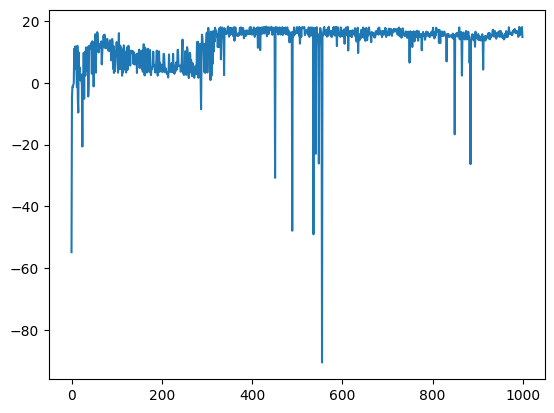

In [374]:
env = Environment(moving_step=0.1)
agent = DQNAgent(env, epsilon_decay=0.99)
rewards = agent.train(num_episodes=1000)
plt.plot(rewards)
plt.show()

In [375]:
agent.inference()

Step: 0, State: [0.2 0.3], Action: 0, Next State: [0.2 0.3], Reward: 1
Step: 1, State: [0.2 0.4], Action: 0, Next State: [0.2 0.4], Reward: -0.05
Step: 2, State: [0.2 0.5], Action: 0, Next State: [0.2 0.5], Reward: -0.05
Step: 3, State: [0.2 0.6], Action: 0, Next State: [0.2 0.6], Reward: -0.05
Step: 4, State: [0.2        0.70000005], Action: 0, Next State: [0.2        0.70000005], Reward: -0.05
Step: 5, State: [0.2       0.8000001], Action: 0, Next State: [0.2       0.8000001], Reward: -0.05
Step: 6, State: [0.2       0.9000001], Action: 0, Next State: [0.2       0.9000001], Reward: 1
Step: 7, State: [0.2       1.0000001], Action: 0, Next State: [0.2       1.0000001], Reward: -0.05
Step: 8, State: [0.3       1.0000001], Action: 3, Next State: [0.3       1.0000001], Reward: -0.05
Step: 9, State: [0.4       1.0000001], Action: 3, Next State: [0.4       1.0000001], Reward: 1
Step: 10, State: [0.5       1.0000001], Action: 3, Next State: [0.5       1.0000001], Reward: 2
Step: 11, State: [

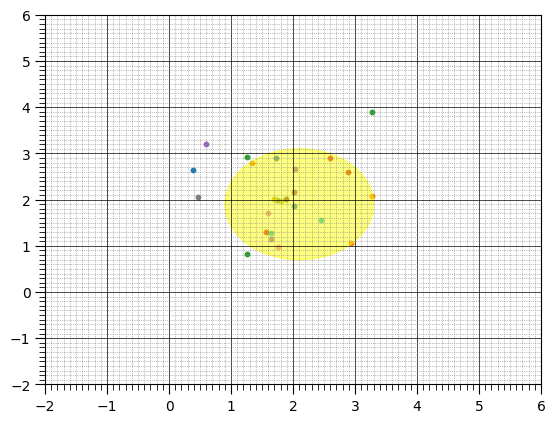

In [376]:
agent.env.render()

## ag ag

episode: 0, Total rewards: -14.00000000000005, Current loss: 31.9038308262825, epsilon: 0.891
episode: 1, Total rewards: -28.000000000000064, Current loss: 301.6108218431473, epsilon: 0.88209
episode: 2, Total rewards: 6.999999999999998, Current loss: 243.8481228351593, epsilon: 0.8732691
episode: 3, Total rewards: -3.999999999999986, Current loss: 87.0015611872077, epsilon: 0.8645364090000001
episode: 4, Total rewards: 3.0000000000000098, Current loss: 94.56423416733742, epsilon: 0.85589104491
episode: 5, Total rewards: -42.9999999999998, Current loss: 278.3845506310463, epsilon: 0.8473321344609
episode: 6, Total rewards: -68.99999999999982, Current loss: 418.6756544113159, epsilon: 0.8388588131162911
episode: 7, Total rewards: -27.000000000000068, Current loss: 347.374663323164, epsilon: 0.8304702249851281
episode: 8, Total rewards: 2.0000000000000004, Current loss: 194.02877074480057, epsilon: 0.8221655227352769
episode: 9, Total rewards: -16.000000000000068, Current loss: 132.03603

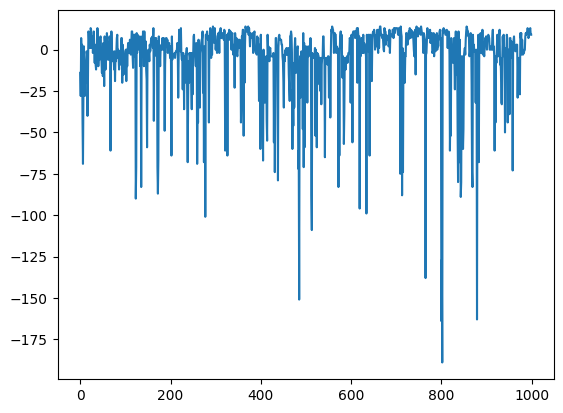

In [364]:
env = Environment(moving_step=0.1)
agent = DQNAgent(env, epsilon_decay=0.99)
rewards = agent.train(num_episodes=1000)
plt.plot(rewards)
plt.show()

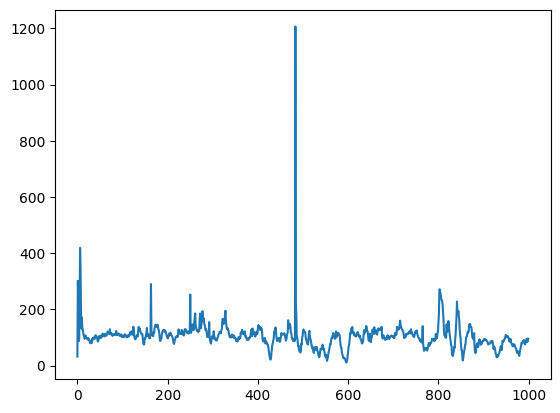

In [365]:
plt.plot(agent.loss)
plt.show()

In [366]:
agent.inference()

Step: 0, State: [0.1 0. ], Action: 3, Next State: [0.1 0. ], Reward: -0.05
Step: 1, State: [0.2 0. ], Action: 3, Next State: [0.2 0. ], Reward: -0.05
Step: 2, State: [0.3 0. ], Action: 3, Next State: [0.3 0. ], Reward: -0.05
Step: 3, State: [0.4 0. ], Action: 3, Next State: [0.4 0. ], Reward: 0.95
Step: 4, State: [0.5 0. ], Action: 3, Next State: [0.5 0. ], Reward: -0.05
Step: 5, State: [0.6 0. ], Action: 3, Next State: [0.6 0. ], Reward: -0.05
Step: 6, State: [0.70000005 0.        ], Action: 3, Next State: [0.70000005 0.        ], Reward: -0.05
Step: 7, State: [0.8000001 0.       ], Action: 3, Next State: [0.8000001 0.       ], Reward: -0.05
Step: 8, State: [0.9000001 0.       ], Action: 3, Next State: [0.9000001 0.       ], Reward: -0.05
Step: 9, State: [1.0000001 0.       ], Action: 3, Next State: [1.0000001 0.       ], Reward: -0.05
Step: 10, State: [1.1000001 0.       ], Action: 3, Next State: [1.1000001 0.       ], Reward: 0.95
Step: 11, State: [1.2000002 0.       ], Action: 3, N

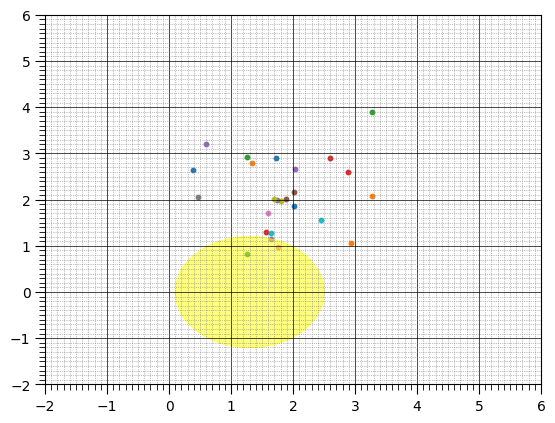

In [367]:
agent.env.render()

## ag

episode: 0, Total rewards: 364.99999999999983, Current loss: 853.687695980072, epsilon: 0.855
episode: 1, Total rewards: 135.99999999999997, Current loss: 12274.967134475708, epsilon: 0.8122499999999999
episode: 2, Total rewards: 340.9999999999997, Current loss: 2765.621723175049, epsilon: 0.7716374999999999
episode: 3, Total rewards: 185.99999999999963, Current loss: 2708.837784767151, epsilon: 0.7330556249999999
episode: 4, Total rewards: 410.9999999999996, Current loss: 2455.045111656189, epsilon: 0.6964028437499998
episode: 5, Total rewards: 482.99999999999915, Current loss: 2662.9147605895996, epsilon: 0.6615827015624998
episode: 6, Total rewards: 277.99999999999926, Current loss: 2530.6007776260376, epsilon: 0.6285035664843748
episode: 7, Total rewards: 151.9999999999999, Current loss: 2377.8847455978394, epsilon: 0.597078388160156
episode: 8, Total rewards: 654.0000000000008, Current loss: 2404.7151288986206, epsilon: 0.5672244687521482
episode: 9, Total rewards: 269.99999999999

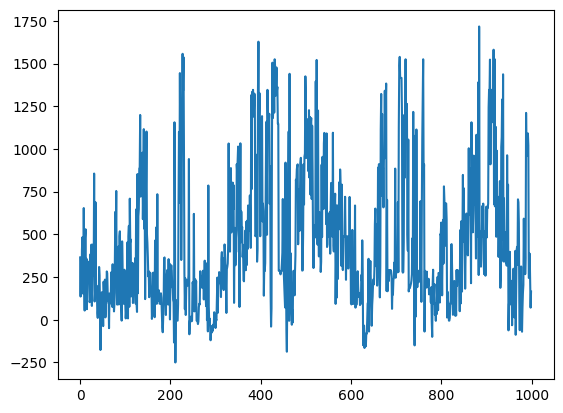

In [356]:
env = Environment(moving_step=0.5)
agent = DQNAgent(env)
rewards = agent.train(num_episodes=1000)
plt.plot(rewards)
plt.show()

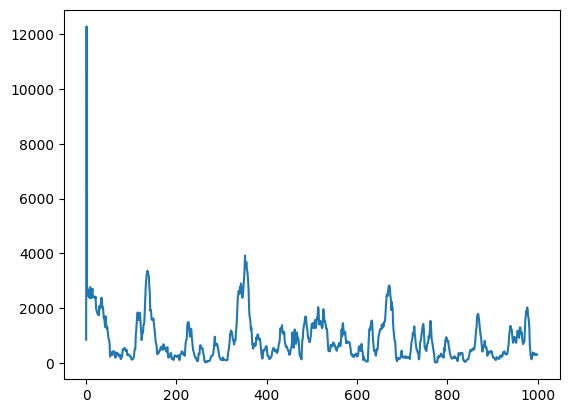

In [357]:
plt.plot(agent.loss)
plt.show()

In [358]:
agent.inference()

Step: 0, State: [0.  0.5], Action: 0, Next State: [0.  0.5], Reward: -0.05
Step: 1, State: [0. 1.], Action: 0, Next State: [0. 1.], Reward: 0.95
Step: 2, State: [0.  1.5], Action: 0, Next State: [0.  1.5], Reward: 0.95
Step: 3, State: [0. 2.], Action: 0, Next State: [0. 2.], Reward: 1.95
Step: 4, State: [0.  2.5], Action: 0, Next State: [0.  2.5], Reward: 2.95
Step: 5, State: [0. 3.], Action: 0, Next State: [0. 3.], Reward: 2.95
Step: 6, State: [0.  3.5], Action: 0, Next State: [0.  3.5], Reward: 1.95
Step: 7, State: [0. 4.], Action: 0, Next State: [0. 4.], Reward: 0.95
Step: 8, State: [0.  3.5], Action: 1, Next State: [0.  3.5], Reward: 1.95
Step: 9, State: [0. 4.], Action: 0, Next State: [0. 4.], Reward: 0.95
Step: 10, State: [0.  3.5], Action: 1, Next State: [0.  3.5], Reward: 1.95
Step: 11, State: [0. 4.], Action: 0, Next State: [0. 4.], Reward: 0.95
Step: 12, State: [0.  3.5], Action: 1, Next State: [0.  3.5], Reward: 1.95
Step: 13, State: [0. 4.], Action: 0, Next State: [0. 4.], 

## test again again
- using long moving step

In [347]:
0.9 * (0.95 ** 100)

0.005328476298300598

===============================Update Target Network===============================

episode: 0, Total rewards: 382.9999999999993, Current loss: 1161.3537483215332
episode: 1, Total rewards: 504.9999999999993, Current loss: 2680.9063386917114
episode: 2, Total rewards: 216.9999999999992, Current loss: 2628.1140966415405
episode: 3, Total rewards: 270.99999999999943, Current loss: 2266.825493812561
episode: 4, Total rewards: 370.9999999999995, Current loss: 2168.061625480652
episode: 5, Total rewards: 470.9999999999992, Current loss: 2121.8484992980957
episode: 6, Total rewards: 118.00000000000018, Current loss: 2198.6000967025757
episode: 7, Total rewards: 299.99999999999926, Current loss: 2196.1130113601685
episode: 8, Total rewards: 379.9999999999994, Current loss: 2226.4800395965576
episode: 9, Total rewards: 240.99999999999957, Current loss: 2328.3214588165283
===============================Update Target Network===============================

episode: 10, Total rewards: 315.999999

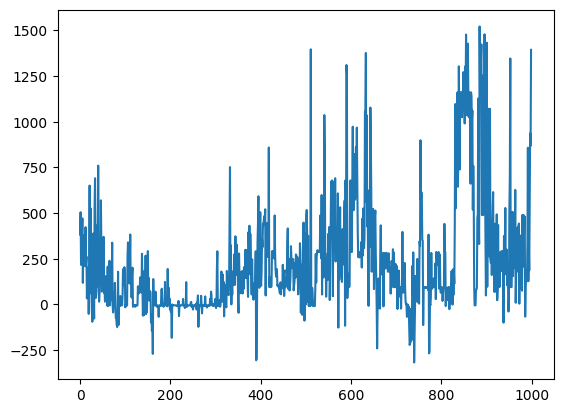

In [349]:
env = Environment(moving_step=0.5)
agent = DQNAgent(env)
rewards = agent.train(num_episodes=1000)
plt.plot(rewards)
plt.show()

In [350]:
agent.inference()

Step: 0, State: [0.  0.5], Action: 0, Next State: [0.  0.5], Reward: -0.05
Step: 1, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 2, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 3, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 4, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 5, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 6, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 7, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 8, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 9, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 10, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 11, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 12, State: [0.  0.5], Action: 4, Next State: [0.  0.5], Reward: -0.05
Step: 13, State: [0.  

## test again

- this time just modify the init weight(randomly init)

===============================Update Target Network===============================

episode: 0, Total rewards: 82.00000000000004, Current loss: 129.4617793560028
episode: 1, Total rewards: 129.00000000000003, Current loss: 331.2274868488312
episode: 2, Total rewards: 20.999999999999957, Current loss: 340.6341668367386
episode: 3, Total rewards: -71.99999999999984, Current loss: 307.0332896709442
episode: 4, Total rewards: 57.00000000000004, Current loss: 288.76909375190735
episode: 5, Total rewards: -16.00000000000004, Current loss: 268.2979362010956
episode: 6, Total rewards: 23.999999999999954, Current loss: 264.20953369140625
episode: 7, Total rewards: 727.0000000000003, Current loss: 337.59316754341125
episode: 8, Total rewards: 17.99999999999997, Current loss: 603.3266687393188
episode: 9, Total rewards: -21.000000000000057, Current loss: 525.7722263336182
===============================Update Target Network===============================

episode: 10, Total rewards: 67.000000000

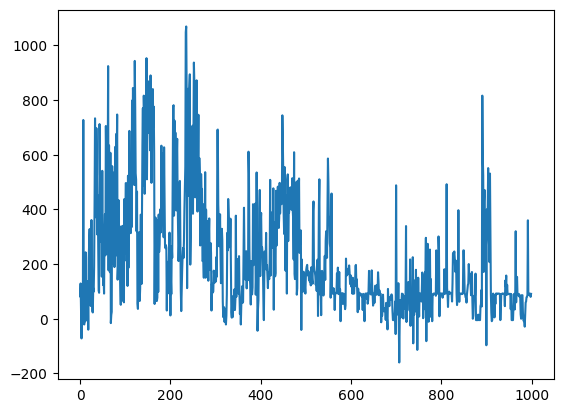

In [330]:
env = Environment()
agent = DQNAgent(env)
rewards = agent.train(num_episodes=1000)
plt.plot(rewards)
plt.show()

In [332]:
agent.inference()

Step: 0, State: [0.1 0. ], Action: 3, Next State: [0.1 0. ], Reward: -0.05
Step: 1, State: [0.1 0.1], Action: 0, Next State: [0.1 0.1], Reward: -0.05
Step: 2, State: [0.1 0.2], Action: 0, Next State: [0.1 0.2], Reward: -0.05
Step: 3, State: [0.1 0.3], Action: 0, Next State: [0.1 0.3], Reward: -0.05
Step: 4, State: [0.1 0.4], Action: 0, Next State: [0.1 0.4], Reward: -0.05
Step: 5, State: [0.1 0.5], Action: 0, Next State: [0.1 0.5], Reward: 0.95
Step: 6, State: [0.1 0.5], Action: 4, Next State: [0.1 0.5], Reward: 0.95
Step: 7, State: [0.1 0.5], Action: 4, Next State: [0.1 0.5], Reward: 0.95
Step: 8, State: [0.1 0.5], Action: 4, Next State: [0.1 0.5], Reward: 0.95
Step: 9, State: [0.1 0.5], Action: 4, Next State: [0.1 0.5], Reward: 0.95
Step: 10, State: [0.1 0.5], Action: 4, Next State: [0.1 0.5], Reward: 0.95
Step: 11, State: [0.1 0.5], Action: 4, Next State: [0.1 0.5], Reward: 0.95
Step: 12, State: [0.1 0.5], Action: 4, Next State: [0.1 0.5], Reward: 0.95
Step: 13, State: [0.1 0.5], Ac

## test again
- learning rate stop to decay if <= 0.00005
-

===============================Update Target Network===============================

episode: 0, Total rewards: 408.99999999999943, Current loss: 750.0966892242432
episode: 1, Total rewards: 55.00000000000005, Current loss: 794.4030749797821
episode: 2, Total rewards: 49.00000000000005, Current loss: 392.1273715496063
episode: 3, Total rewards: 3.9999999999999645, Current loss: 296.06043815612793
episode: 4, Total rewards: 62.00000000000007, Current loss: 267.795902132988
episode: 5, Total rewards: -3.999999999999969, Current loss: 257.61763894557953
episode: 6, Total rewards: -6.000000000000021, Current loss: 239.99005496501923
episode: 7, Total rewards: 91.99999999999999, Current loss: 229.79026544094086
episode: 8, Total rewards: -2.000000000000032, Current loss: 262.7758423089981
episode: 9, Total rewards: 58.99999999999998, Current loss: 266.8929373025894
===============================Update Target Network===============================

episode: 10, Total rewards: 350.9999999999

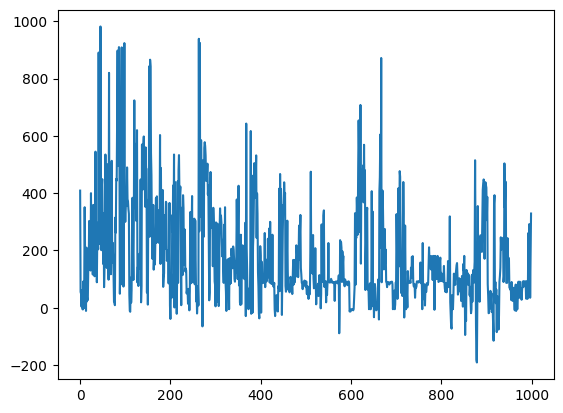

In [316]:
env = Environment()
agent = DQNAgent(env)
rewards = agent.train(num_episodes=1000)
plt.plot(rewards)
plt.show()

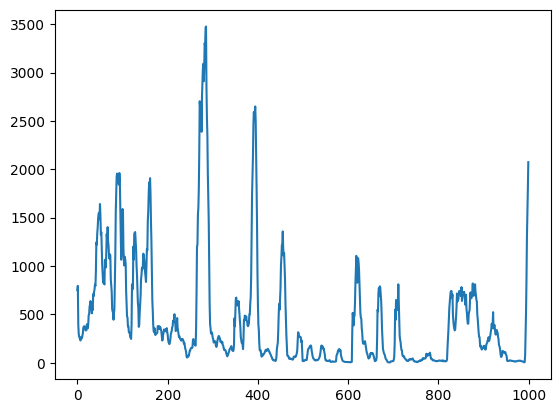

In [318]:
agent.inference()

Step: 0, State: [0.  0.1], Action: 0, Next State: [0.  0.1], Reward: -0.05
Step: 1, State: [0.1 0.1], Action: 3, Next State: [0.1 0.1], Reward: -0.05
Step: 2, State: [0.2 0.1], Action: 3, Next State: [0.2 0.1], Reward: -0.05
Step: 3, State: [0.2 0.2], Action: 0, Next State: [0.2 0.2], Reward: -0.05
Step: 4, State: [0.2 0.3], Action: 0, Next State: [0.2 0.3], Reward: 0.95
Step: 5, State: [0.2 0.4], Action: 0, Next State: [0.2 0.4], Reward: 0.95
Step: 6, State: [0.2 0.5], Action: 0, Next State: [0.2 0.5], Reward: 0.95
Step: 7, State: [0.2 0.6], Action: 0, Next State: [0.2 0.6], Reward: 0.95
Step: 8, State: [0.2        0.70000005], Action: 0, Next State: [0.2        0.70000005], Reward: 0.95
Step: 9, State: [0.2       0.8000001], Action: 0, Next State: [0.2       0.8000001], Reward: 0.95
Step: 10, State: [0.2       0.9000001], Action: 0, Next State: [0.2       0.9000001], Reward: 1.95
Step: 11, State: [0.3       0.9000001], Action: 3, Next State: [0.3       0.9000001], Reward: 1.95
Step: 

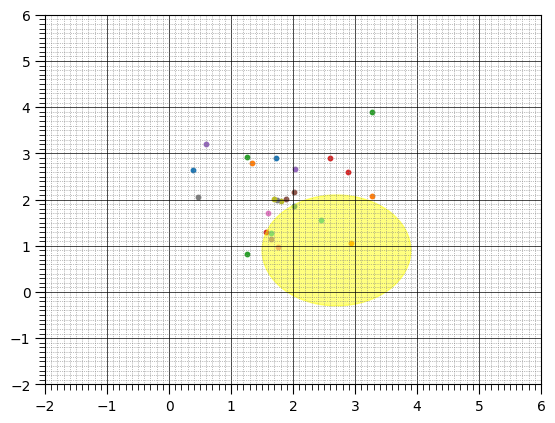

In [320]:
agent.env.render()

In [321]:
agent.train(num_episodes=500)

===============================Update Target Network===============================

episode: 0, Total rewards: 182.99999999999932, Current loss: 2436.330231666565
episode: 1, Total rewards: 91.99999999999953, Current loss: 2540.6965866088867
episode: 2, Total rewards: 87.99999999999935, Current loss: 2817.050537109375
episode: 3, Total rewards: 91.00000000000016, Current loss: 2565.624547958374
episode: 4, Total rewards: 92.00000000000016, Current loss: 2375.670439720154
episode: 5, Total rewards: 59.000000000000064, Current loss: 2045.8582582473755
episode: 6, Total rewards: 92.00000000000016, Current loss: 1708.3048429489136
episode: 7, Total rewards: 90.00000000000016, Current loss: 1364.9441418647766
episode: 8, Total rewards: 57.00000000000004, Current loss: 1131.4945669174194
episode: 9, Total rewards: -4.99999999999999, Current loss: 812.1482257843018
===============================Update Target Network===============================

episode: 10, Total rewards: 92.000000000000

[182.99999999999932,
 91.99999999999953,
 87.99999999999935,
 91.00000000000016,
 92.00000000000016,
 59.000000000000064,
 92.00000000000016,
 90.00000000000016,
 57.00000000000004,
 -4.99999999999999,
 92.00000000000016,
 92.00000000000016,
 92.00000000000016,
 84.00000000000014,
 108.00000000000016,
 92.00000000000016,
 57.00000000000004,
 92.00000000000016,
 92.00000000000016,
 92.00000000000016,
 92.00000000000016,
 70.00000000000011,
 86.00000000000014,
 139.0000000000001,
 141.00000000000006,
 84.00000000000013,
 81.00000000000013,
 92.00000000000016,
 -21.999999999999883,
 77.00000000000011,
 -4.99999999999999,
 -4.99999999999999,
 -4.99999999999999,
 -4.99999999999999,
 88.00000000000014,
 -4.99999999999999,
 63.00000000000008,
 92.00000000000016,
 92.00000000000016,
 91.00000000000016,
 92.00000000000016,
 89.00000000000016,
 91.00000000000016,
 10.999999999999964,
 42.000000000000014,
 -4.99999999999999,
 8.000000000000009,
 25.999999999999943,
 -4.99999999999999,
 32.9999999

Step: 0, State: [0.  0.1], Action: 0, Next State: [0.  0.1], Reward: -0.05
Step: 1, State: [0.  0.2], Action: 0, Next State: [0.  0.2], Reward: -0.05
Step: 2, State: [0.  0.3], Action: 0, Next State: [0.  0.3], Reward: -0.05
Step: 3, State: [0.  0.4], Action: 0, Next State: [0.  0.4], Reward: -0.05
Step: 4, State: [0.  0.5], Action: 0, Next State: [0.  0.5], Reward: -0.05
Step: 5, State: [0.  0.6], Action: 0, Next State: [0.  0.6], Reward: -0.05
Step: 6, State: [0.         0.70000005], Action: 0, Next State: [0.         0.70000005], Reward: -0.05
Step: 7, State: [0.        0.8000001], Action: 0, Next State: [0.        0.8000001], Reward: -0.05
Step: 8, State: [0.        0.9000001], Action: 0, Next State: [0.        0.9000001], Reward: -0.05
Step: 9, State: [0.        0.9000001], Action: 4, Next State: [0.        0.9000001], Reward: -0.05
Step: 10, State: [0.        0.9000001], Action: 4, Next State: [0.        0.9000001], Reward: -0.05
Step: 11, State: [0.        0.9000001], Action: 4,

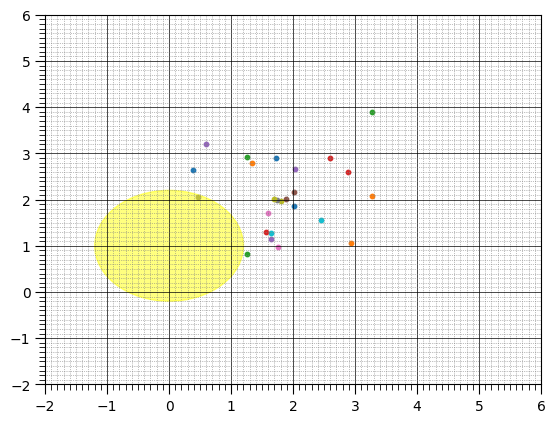

In [325]:
agent.inference()
agent.env.render()

## this test use learning rate decay and epsilon decay

- but learning rate will not stop to decay

episode: 0, Total rewards: 220, Current loss: 32384.972869873047
episode: 1, Total rewards: 2770, Current loss: 115494.27655029297
episode: 2, Total rewards: -1900, Current loss: 147643.57342529297
episode: 3, Total rewards: 780, Current loss: 133567.6587524414
episode: 4, Total rewards: -440, Current loss: 108721.36798095703
episode: 5, Total rewards: 6440, Current loss: 107408.79809570312
episode: 6, Total rewards: -1520, Current loss: 102878.46951293945
episode: 7, Total rewards: 420, Current loss: 104551.44921875
episode: 8, Total rewards: -1150, Current loss: 104241.22546386719
episode: 9, Total rewards: -180, Current loss: 101784.82424926758
episode: 10, Total rewards: -1120, Current loss: 99165.42907714844
episode: 11, Total rewards: 1690, Current loss: 90337.0732421875
episode: 12, Total rewards: 320, Current loss: 92381.52536010742
episode: 13, Total rewards: 820, Current loss: 88166.71844482422
episode: 14, Total rewards: 380, Current loss: 83339.04623413086
episode: 15, Tota

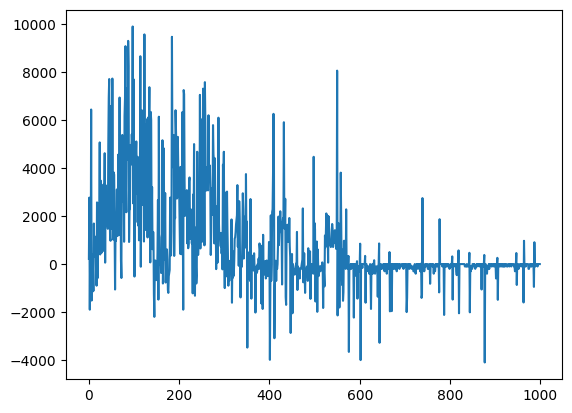

In [289]:

env = Environment()
agent = DQNAgent(env)
rewards = agent.train(num_episodes=1000)
plt.plot(rewards)
plt.show()

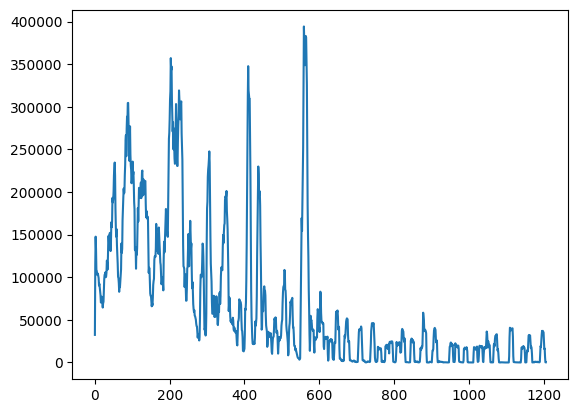

In [294]:
plt.plot(agent.loss)
plt.show()

- 1. if we Punish the movement, it can hardly find the right way to the points.
- 2. if we don't punish the movement, it will just stay.

In [291]:
rewards.append(agent.train(num_episodes=500))

episode: 0, Total rewards: 0, Current loss: 65.56512273742159
episode: 1, Total rewards: -100, Current loss: 124.51998524218023
episode: 2, Total rewards: 0, Current loss: 56.64784367713999
episode: 3, Total rewards: 0, Current loss: 32.3044672961734
episode: 4, Total rewards: -100, Current loss: 37.931397731042516
episode: 5, Total rewards: 0, Current loss: 35.727204100856326
episode: 6, Total rewards: 0, Current loss: 16.494595556383192
episode: 7, Total rewards: 0, Current loss: 35.55014779261039
episode: 8, Total rewards: -100, Current loss: 27.442616188643086
episode: 9, Total rewards: 0, Current loss: 23.071706001049844
episode: 10, Total rewards: -100, Current loss: 24.61096833345105
episode: 11, Total rewards: 0, Current loss: 14.441874906398631
episode: 12, Total rewards: 0, Current loss: 10.663449441616033
episode: 13, Total rewards: -1400, Current loss: 11139.547753347197
episode: 14, Total rewards: -100, Current loss: 18066.458589443246
episode: 15, Total rewards: 0, Curren

KeyboardInterrupt: 

## this one manually adjust lr.

In [258]:
agent.optimizer = optim.Adam(agent.q_network.parameters(), lr=0.0001)
rewards = agent.train(num_episodes=500)

episode: 0, Total rewards: -9.99999999999998, Current loss: 2328.8769766688347
episode: 1, Total rewards: -160.99999999999966, Current loss: 2797.6904096603394
episode: 2, Total rewards: 38.99999999999993, Current loss: 2209.619852900505
episode: 3, Total rewards: 85.00000000000007, Current loss: 3076.978859066963
episode: 4, Total rewards: -9.99999999999998, Current loss: 2312.1621809005737
episode: 5, Total rewards: -9.99999999999998, Current loss: 3093.4653193950653
episode: 6, Total rewards: -8.999999999999986, Current loss: 3069.423755168915
episode: 7, Total rewards: -9.99999999999998, Current loss: 2757.4659078121185
episode: 8, Total rewards: -3.999999999999981, Current loss: 2200.7416050434113
episode: 9, Total rewards: 23.999999999999968, Current loss: 3343.7036809921265
episode: 10, Total rewards: 31.99999999999995, Current loss: 3555.0075373649597
episode: 11, Total rewards: 33.999999999999936, Current loss: 4225.9615116119385
episode: 12, Total rewards: -9.99999999999998, 

In [241]:
0.995 ** 500

0.08157186144027832

In [292]:
agent.inference()

Step: 0, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 1, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 2, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 3, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 4, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 5, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 6, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 7, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 8, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 9, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 10, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 11, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 12, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 13, State: [0. 0.], Action: 4, Next State: [0. 0.], Reward: 0
Step: 14, State: [0. 0.], Action: 4, Next State: [0. 0.], 

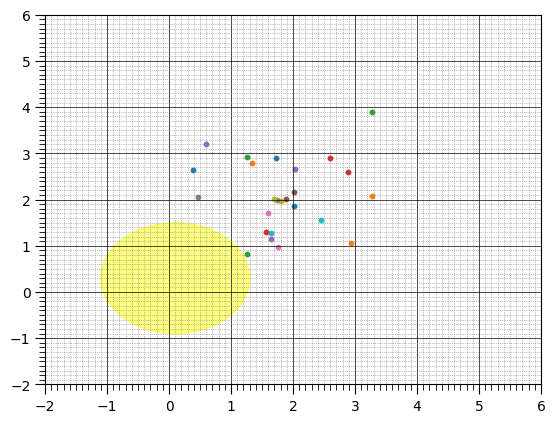

In [261]:

env.render()


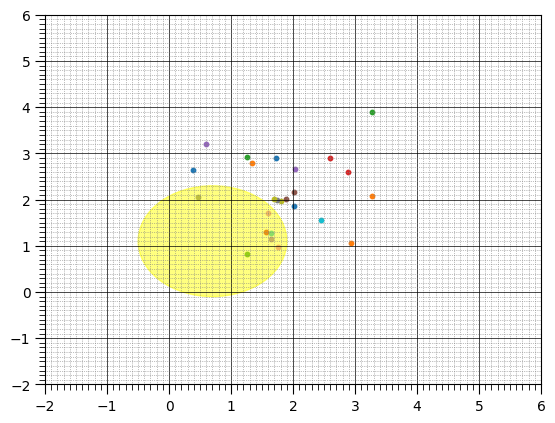

[0.70000005 1.1000001 ] 0


In [197]:
x, y = env.step(4)
env.render()
print(x, y)

## test 3

## other test

In [ ]:
##

In [19]:
torch.FloatTensor(cs).unsqueeze(0).shape

torch.Size([1, 2])

In [160]:
x = np.array([0, 0])
x[0] = x[0] - 2.1
x

array([-2,  0])

In [ ]:
def reset(self, initialize_method=np.array([.0, .0]).astype(np.float32)):
        if self.disk_number == 1:

            if isinstance(initialize_method, np.ndarray) and initialize_method.shape == (2,):
                self.state = initialize_method

            if isinstance(initialize_method, list) and len(initialize_method) == 2:
                self.state = np.array(initialize_method)
            if isinstance(initialize_method, tuple) and len(initialize_method) == 2:
                self.state = np.array(initialize_method)
            if isinstance(initialize_method, str) and initialize_method == "random":
                self.state = np.array([random.uniform(*self.x_range), random.uniform(*self.y_range)])


            self.update_coverd_number()
            self
            return self.state
        else:
            return NotImplementedError

In [236]:
im = np.array([.0, .0]).astype(np.float32)

array([0., 0.], dtype=float32)